# Exploratory Data Analysis

## New York Time Articles - Sanity Check

### Goal of this notebook

> Undestand extracted data structures and check for eventuals flaws in the extraction.

### Sanity Check

Import libraries.

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from textblob import TextBlob
import matplotlib.pyplot as plt
from src.paths import LOCAL_INTERIM_DATA_PATH
from src.visualization.Plotter import show_wordcloud
from src.processing.IOController import load_normalized_nyt_df
from src.processing.DataFrameManipulator import breakdown_cat_distribution
tqdm.pandas()

Load consolidated DataFrame and check columns, datatypes and missing values.
> Most columns have object data types, our index columns is the `_id` and there are some missing values which must be checked as we go along.

In [8]:
df = load_normalized_nyt_df(LOCAL_INTERIM_DATA_PATH / 'nyt-articles-consolidated.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21116 entries, 0 to 8
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   abstract           20679 non-null  object             
 1   web_url            21116 non-null  object             
 2   snippet            20630 non-null  object             
 3   lead_paragraph     20603 non-null  object             
 4   source             21116 non-null  object             
 5   multimedia         21116 non-null  object             
 6   headline           21116 non-null  object             
 7   keywords           21116 non-null  object             
 8   pub_date           21116 non-null  datetime64[ns, UTC]
 9   document_type      21116 non-null  object             
 10  news_desk          21116 non-null  object             
 11  section_name       21116 non-null  object             
 12  subsection_name    13857 non-null  object         

Check the first 3 rows to get a better feeling of what is the data like.

> There's no field for the complete article text, that could be accomplished via a further web scrapping on the `web_url`. For simplitiy purposes I'm gonna consider the `abstract` as a text reference for the documents. Apparently `word_count` and `section_name` and `subsections_name` look like interesting fields to investigate since they carry some structure to the text which may be generalized via a Machine Learning model for predicting their corresponding classes. Moreover, `pub_date` will be interesting to capture trends over time.

In [10]:
df.head(3).T

,0,1,2
abstract,A Times video investigation identified Chinese...,Anger at lockdowns and mask mandates provides ...,Doctors are seeing more cases a day than they ...
web_url,https://www.nytimes.com/2020/07/19/world/asia/...,https://www.nytimes.com/2020/07/19/business/me...,https://www.nytimes.com/2020/07/20/world/asia/...
snippet,A Times video investigation identified Chinese...,Anger at lockdowns and mask mandates provides ...,Doctors are seeing more cases a day than they ...
lead_paragraph,As the coronavirus pandemic continues to drive...,"COLUMBUS, Ohio — If you’ve been following Gov....",Hong Kong once seemed like a model for how to ...
source,The New York Times,The New York Times,The New York Times
multimedia,[],"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","[{'rank': 0, 'subtype': 'xlarge', 'caption': N..."
headline,{'main': 'China Is Using Uighur Labor to Produ...,{'main': 'An Ex-Times Reporter. An Ohio Weddin...,"{'main': 'Once a Model City, Hong Kong Grapple..."
keywords,"[{'name': 'subject', 'value': 'Uighurs (Chines...","[{'name': 'subject', 'value': 'Coronavirus (20...","[{'name': 'glocations', 'value': 'Hong Kong', ..."
pub_date,2020-07-19 20:00:09+00:00,2020-07-20 00:30:07+00:00,2020-07-20 12:55:30+00:00
document_type,article,article,article


Check missing values.
> It's always a good practice to check for missing values, they usually have to be treated while doing feature engineering. Additionally there might have been errors in the extraction which may the caught in this phase. In our case, the missing values do not look to impact our end analysis since the scope is to understand build a Text Classifier which shall in a first draft use only the text as features. Everything else can be ignored, except from the dependent variable (target).

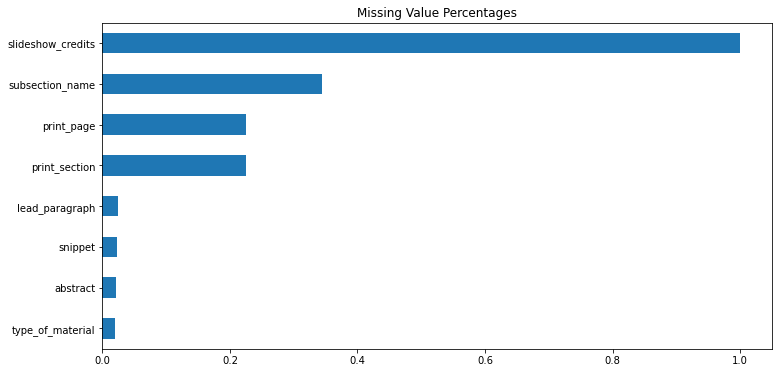

In [72]:
tmp = (df.isna().sum() / df.shape[0]).where(lambda x: x>0).dropna().sort_values(ascending=True)
tmp.plot(kind='barh', figsize=(12,6), title='Missing Value Percentages')

Exploring the data it's noticeable the following columns as categorical variables. I usually tend to check their distribution to try and catch some insights.

> In this case `news_desk` it's worthwhile to mention that its top 6 categories may be used for our Classifier. The further ones should be ignored or accumulated into an 'Others' category due to their low volume. That's necessary to avoid jeopardizing the Classifier's performance due to lack of statistical representation. The other columns might be intersting for further breakdowns of our classifier in future versions.

In [56]:
categorical_columns = ['source', 'document_type', 'news_desk', 'section_name', 'subsection_name', 'type_of_material']
breakdown_cat_distribution(df, categorical_columns)

DatFrame columns breakdown

Column `source` distribution


,count,percentage
The New York Times,"21,114",100.0%
International New York Times,2,0.0%



Column `document_type` distribution


,count,percentage
article,"19,883",94.2%
multimedia,"1,233",5.8%



Column `news_desk` distribution


,count,percentage
Foreign,"6,722",31.8%
Business,"5,256",24.9%
Sports,"3,631",17.2%
Politics,"2,570",12.2%
Science,"1,758",8.3%
U.S.,"1,006",4.8%
World,96,0.5%
Arts,50,0.2%
Movies,12,0.1%
Technology,11,0.1%



Column `section_name` distribution


,count,percentage
World,"6,784",32.1%
Business Day,"3,890",18.4%
U.S.,"3,659",17.3%
Sports,"3,626",17.2%
Technology,"1,045",4.9%
Health,887,4.2%
Science,860,4.1%
Your Money,184,0.9%
Arts,65,0.3%
Real Estate,39,0.2%



Column `subsection_name` distribution


,count,percentage
NaN,"7,259",34.4%
Politics,"2,877",13.6%
Europe,"2,351",11.1%
Asia Pacific,"1,996",9.5%
Middle East,885,4.2%
Media,575,2.7%
Elections,560,2.7%
Americas,541,2.6%
DealBook,511,2.4%
Economy,397,1.9%



Column `type_of_material` distribution


,count,percentage
News,"19,621",92.9%
Interactive Feature,798,3.8%
NaN,429,2.0%
News Analysis,113,0.5%
briefing,86,0.4%
Biography,22,0.1%
Obituary (Obit),14,0.1%
Review,14,0.1%
Slideshow,6,0.0%
Web Log,4,0.0%


Check extraction distribution over time.

> Checking the data over time is also a good practice for understading the dataset and spot possible extraction failures. In this case we can see that the distribution of desks are very stable across time, which sounds as a good indicator of sound extraction! Though in January/2019 and June/2020 the volumes are lower, which might indicate failures interacting with the API. Here I'm should have a look on our extractor logs to check if everything is ok.

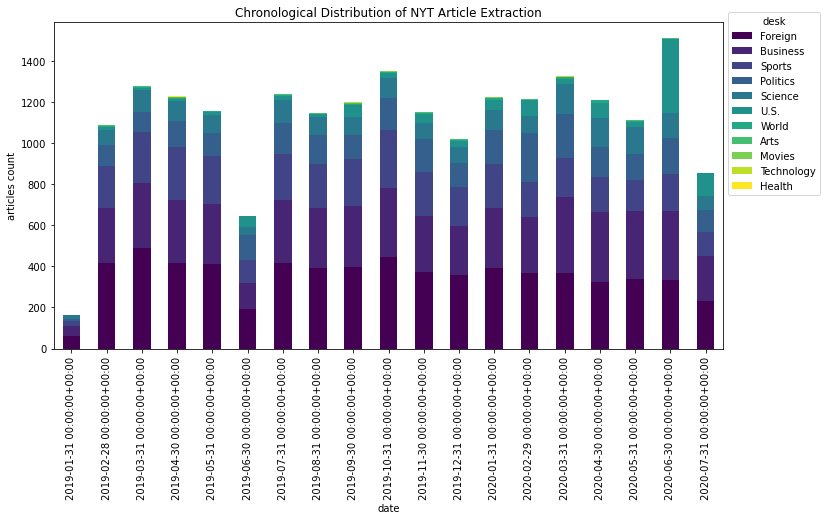

In [261]:
tmp = df.groupby([pd.Grouper(key='pub_date', freq='M'), 'news_desk']).size().unstack().sort_index()
column_order = tmp.sum().sort_values(ascending=False).index
tmp = tmp[column_order]
tmp.plot(kind='bar', stacked=True, colormap='viridis',
         figsize=(12,6),
         title='Chronological Distribution of NYT Article Extraction')\
   .set(xlabel='date', ylabel='articles count')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.75), title='desk')

Check the distribution of word_count.

> Here we're looking at average values, but in many desks the value is null... This columns is thus not trustworthy, and maybe we could create our own feature from the abstract field.

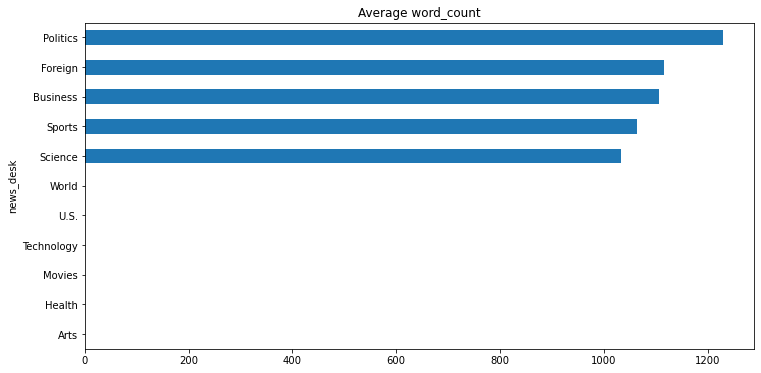

In [103]:
tmp = df.groupby(['news_desk']).word_count.mean().sort_values()
tmp.plot(kind='barh', figsize=(12,6), title='Average word_count')

Check the new feature.

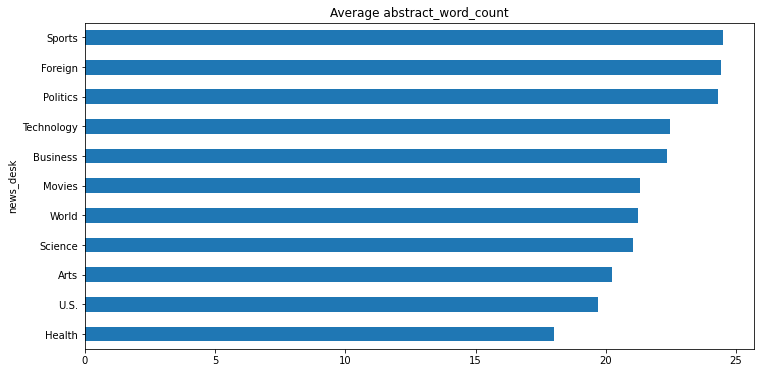

In [104]:
df['abstract_word_count'] = df.abstract.str.split().apply(lambda x: len(x) if isinstance(x, list) else np.nan)
tmp = df.groupby(['news_desk']).abstract_word_count.mean().sort_values()
tmp.plot(kind='barh', figsize=(12,6), title='Average abstract_word_count')

Cross the two features via scatterplot.

> `abstract_word_count` was not a good proxy for `word_count`, since we can see no correlation looking at the plot below. Let's keep the feature for now, but apparently that's something we shall not use in the future.

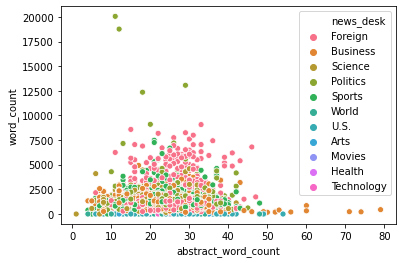

In [329]:
_ = sns.scatterplot(df['abstract_word_count'], df['word_count'], hue=df['news_desk'])

### Conclusion

> The dataset seems to be trustworthy although there seems to be some minor inconsistencies such as missing and null values. The apparent low volumes in some periods may be investigated further, but for simplicity purposes we may carry on with the current one, since it should not jeopardize the main outcome of this project of building a Text Classifier.